In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import skew, kurtosis
from sklearn.metrics import classification_report
from scipy.signal import welch  # Import Welch's method for band power computation
from scipy.stats import entropy  # Import entropy for spectral entropy calculation
from scipy.stats import moment
from scipy.signal import find_peaks

# Load EEG data
data = np.load('A01T.npz')  
signal = data['s']
event_types = data['etyp'].T[0]
event_positions = data['epos'].T[0]
event_durations = data['edur'].T[0]

# Extract signals & labels
signals = []
trial_types = []

for i in range(9, len(event_positions) - 1):  
    event_type = event_types[i]
    next_event_type = event_types[i + 1]
    
    if event_type == 768:  # If it's a trial event
        pos = event_positions[i+1]
        #dur = event_durations[i]
        trial_signal = signal[pos+750:pos+1500, 21]  # Extract EEG channel 11
        signals.append(trial_signal)
        trial_types.append(next_event_type)  # Label is the next event type

# Feature extraction

def hjorth_parameters(signal):
    """ Compute Hjorth mobility and complexity """
    first_deriv = np.diff(signal)
    second_deriv = np.diff(first_deriv)

    var_zero = np.var(signal) if np.var(signal) != 0 else 1e-6  # Avoid division by zero
    var_diff = np.var(first_deriv) if np.var(first_deriv) != 0 else 1e-6
    var_diff2 = np.var(second_deriv) if np.var(second_deriv) != 0 else 1e-6

    mobility = np.sqrt(var_diff / var_zero)
    complexity = np.sqrt(var_diff2 / var_diff)

    return mobility, complexity

def compute_band_power(trial, fs=256):
    """ Compute power in Alpha, Beta, Theta, and Gamma bands using Welch's method """
    f, psd = welch(trial, fs=fs, nperseg=128)

    alpha_power = np.sum(psd[(f >= 8) & (f <= 12)])  # Alpha: 8-12 Hz
    beta_power = np.sum(psd[(f >= 12) & (f <= 30)])  # Beta: 12-30 Hz
    theta_power = np.sum(psd[(f >= 4) & (f <= 8)])  # Theta: 4-8 Hz
    gamma_power = np.sum(psd[(f >= 30) & (f <= 40)])  # Gamma: 30-40 Hz

    return alpha_power, beta_power, theta_power, gamma_power


        
def extract_enhanced_features(trial_signals):
    features = []
    for trial in trial_signals:
        # Time-domain features
        mean_val = np.mean(trial)
        std_val = np.std(trial)
        skew_val = skew(trial)
        kurt_val = kurtosis(trial)
        max_val = np.max(trial)
        min_val = np.min(trial)
        peak_count, _ = find_peaks(trial)  # Number of peaks

        # Frequency-domain features
        alpha, beta, theta, gamma = compute_band_power(trial)
        band_ratio_alpha_beta = alpha / beta if beta != 0 else 0

        # Nonlinear features
        mobility, complexity = hjorth_parameters(trial)
        spectral_entropy = entropy(np.abs(trial) + 1e-6)

        trial_features = [
            mean_val, std_val, skew_val, kurt_val, max_val, min_val, 
            alpha, beta, theta, gamma, band_ratio_alpha_beta,
            mobility, complexity, spectral_entropy,
            len(peak_count)
        ]
        features.append(trial_features)
    
    return np.array(features)

# Compute features
signals_features = extract_enhanced_features(signals)


print(signals_features.shape)
# Encode labels
label_encoder = LabelEncoder()
trial_types_encoded = label_encoder.fit_transform(np.array(trial_types))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(signals_features, trial_types_encoded, test_size=0.3, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LTC (seq_len=15, feature_dim=1)
X_train = X_train.reshape(X_train.shape[0], 15, 1)
X_test = X_test.reshape(X_test.shape[0], 15, 1)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

AttributeError: 'list' object has no attribute 'shape'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class LTC_Cell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LTC_Cell, self).__init__()
        self.hidden_dim = hidden_dim
        self.W_xh = nn.Linear(input_dim, hidden_dim)  # Input transformation
        self.W_hh = nn.Linear(hidden_dim, hidden_dim, bias=False)  # Recurrent transformation
        self.W_tau = nn.Linear(hidden_dim, hidden_dim)  # Time constant control
        self.layer_norm = nn.LayerNorm(hidden_dim)  # Normalize hidden state

    def forward(self, x, h):
        tau = torch.sigmoid(self.W_tau(h)) + 0.1  # Ensure tau is positive
        dh = -h / tau + torch.tanh(self.W_xh(x) + self.W_hh(h))
        h_next = self.layer_norm(h + 0.1 * dh)  # Apply layer normalization
        return h_next

class Improved_LTC_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.3):
        super(Improved_LTC_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.ltc_cell = LTC_Cell(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Regularization
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_dim)  # Initialize hidden state

        for t in range(seq_len):
            h = self.ltc_cell(x[:, t, :], h)  # Recurrent update

        h = self.dropout(h)  # Apply dropout
        output = self.fc(h)  # Output layer
        return output


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model parameters
input_dim = 1  # Each feature is treated as an individual timestep
hidden_dim = 64  # Increased hidden units for better learning
output_dim = len(label_encoder.classes_)  # Number of classes
dropout_rate = 0.4  # Increased dropout

model = Improved_LTC_RNN(input_dim, hidden_dim, output_dim, dropout_rate)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

# Training loop with early stopping
num_epochs = 1000
best_loss = float('inf')
patience = 15  # Stop training if no improvement for 15 epochs
patience_counter = 0
batch_size = 64

train_losses, test_losses, accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    # Validation step
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())

        predictions = torch.argmax(test_output, axis=1)
        accuracy = (predictions == y_test).float().mean().item()
        accuracies.append(accuracy)

    # Reduce learning rate if needed
    scheduler.step(test_loss)

    # Early stopping
#    if test_loss.item() < best_loss:
#        best_loss = test_loss.item()
#        patience_counter = 0  # Reset counter if loss improves
#    else:
#        patience_counter += 1

 #   if patience_counter >= patience:
 #       print(f"Early stopping at epoch {epoch}")
 #       break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Test Loss = {test_loss.item():.4f}, Accuracy = {accuracy:.4f}")



C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss = 2.1334, Test Loss = 1.5732, Accuracy = 0.2644
Epoch 10: Train Loss = 1.5391, Test Loss = 1.5224, Accuracy = 0.2989
Epoch 20: Train Loss = 1.4934, Test Loss = 1.5205, Accuracy = 0.2299
Epoch 30: Train Loss = 1.5115, Test Loss = 1.5214, Accuracy = 0.2529
Epoch 40: Train Loss = 1.5119, Test Loss = 1.5172, Accuracy = 0.2414
Epoch 50: Train Loss = 1.4936, Test Loss = 1.5185, Accuracy = 0.2414
Epoch 60: Train Loss = 1.5069, Test Loss = 1.5174, Accuracy = 0.2759
Epoch 70: Train Loss = 1.5060, Test Loss = 1.5180, Accuracy = 0.2299
Epoch 80: Train Loss = 1.4983, Test Loss = 1.5193, Accuracy = 0.2529
Epoch 90: Train Loss = 1.4993, Test Loss = 1.5181, Accuracy = 0.2529
Epoch 100: Train Loss = 1.4998, Test Loss = 1.5174, Accuracy = 0.2529
Epoch 110: Train Loss = 1.4822, Test Loss = 1.5174, Accuracy = 0.2529
Epoch 120: Train Loss = 1.4936, Test Loss = 1.5174, Accuracy = 0.2644
Epoch 130: Train Loss = 1.5103, Test Loss = 1.5174, Accuracy = 0.2644
Epoch 140: Train Loss = 1.4892,

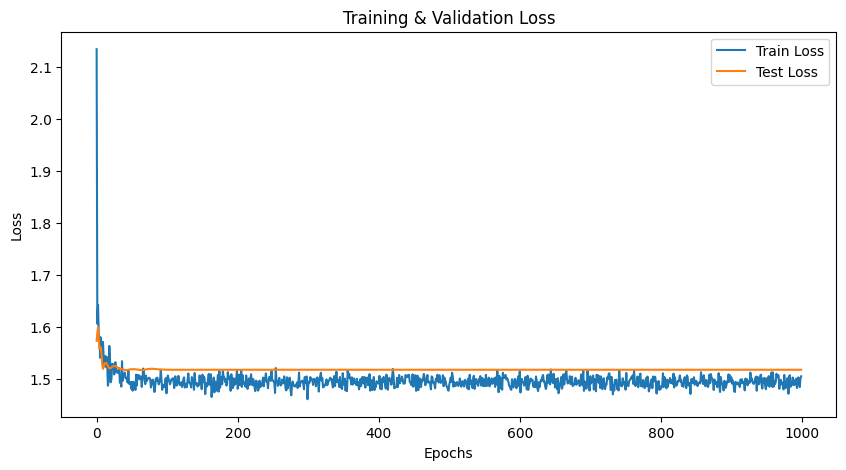

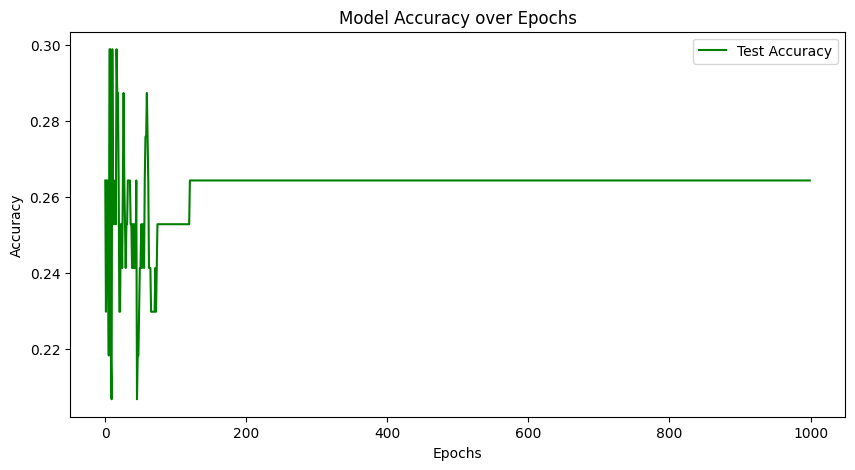

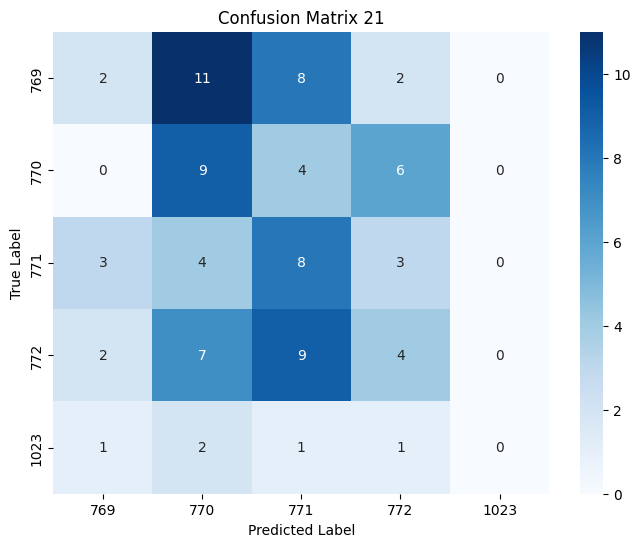

Classification Report:
               precision    recall  f1-score   support

         769       0.25      0.09      0.13        23
         770       0.27      0.47      0.35        19
         771       0.27      0.44      0.33        18
         772       0.25      0.18      0.21        22
        1023       1.00      0.00      0.00         5

    accuracy                           0.26        87
   macro avg       0.41      0.24      0.20        87
weighted avg       0.30      0.26      0.23        87



In [4]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot Accuracy Trend
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Test Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy over Epochs")
plt.legend()
plt.show()

# Generate Predictions for Confusion Matrix
with torch.no_grad():
    test_output = model(X_test)
    test_predictions = torch.argmax(test_output, axis=1)

# Convert to Numpy for Visualization
y_true = y_test.numpy()
y_pred = test_predictions.numpy()

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix 21")
#plt.show()
plt.savefig("confusion_matrix21.png", dpi=300, bbox_inches='tight')
plt.show()

class_report = classification_report(y_true, y_pred, target_names=[str(label) for label in label_encoder.classes_], zero_division=1)
print("Classification Report:\n", class_report)
